In [1]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Maximum, MaxPooling3D, Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Input

import numpy as np
import operator
import pandas as pd

from util.common import to_rgb_img, to_categorical
from util.ccp import CCP_COLOR_MAP
from util.io import open_images

Using TensorFlow backend.


In [9]:
DATASET_X_PATH = '/home/danfergo/SIG/Code/Experiments/data/ccp/x'
DATASET_Y_PATH = '/home/danfergo/SIG/Code/Experiments/data/ccp/y'
I_SIZE = 150

In [ ]:
import os
import numpy as np 

from util.io import open_images 
from util.common import to_categorical

import imp  
import util.io
imp.reload(util.io)  

train_x = np.array(open_images(DATASET_X_PATH + '/train'))

train_y = open_images(DATASET_Y_PATH + '/train', expand_dims=False)
train_y = np.array(to_categorical(train_y))

validation_x = np.array(open_images(DATASET_X_PATH + '/validation'))

validation_y = open_images(DATASET_Y_PATH + '/validation', expand_dims=False)
validation_y = np.array(to_categorical(validation_y))

# np.save(DATASET_X_PATH + '/train_x.npy', train_x)
# np.save(DATASET_Y_PATH + '/train_y.npy', train_y)
# np.save(DATASET_X_PATH + '/validation_x.npy', validation_x)
# np.save(DATASET_Y_PATH + '/validation_y.npy', validation_y)

In [10]:
import numpy as np 

train_x = np.load(DATASET_X_PATH + '/train_x.npy')
train_y = np.load(DATASET_Y_PATH + '/train_y.npy')
validation_x = np.load(DATASET_X_PATH + '/validation_x.npy')
validation_y = np.load(DATASET_Y_PATH + '/validation_y.npy')

(804, 150, 150, 3)
(804, 150, 150, 58)
(89, 150, 150, 3)
(89, 150, 150, 58)


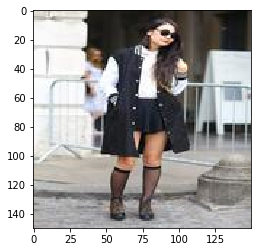

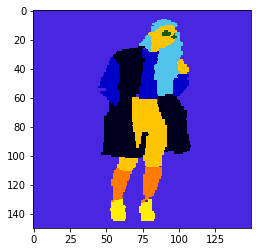

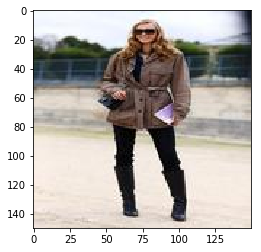

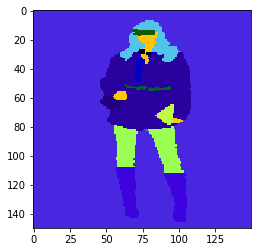

In [4]:
import imp  
import util.common
imp.reload(util.common)  

print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)

plt.imshow(np.uint8(train_x[0]))
plt.show()

plt.imshow(np.uint8(util.common.to_rgb_img(train_y[0], CCP_COLOR_MAP, argmax=True)))
plt.show()

plt.imshow(np.uint8(validation_x[0]))
plt.show()

plt.imshow(np.uint8(util.common.to_rgb_img(validation_y[0], CCP_COLOR_MAP, argmax=True)))
plt.show()

In [4]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Activation, Conv2DTranspose, Lambda
from keras import regularizers
from keras.models import Sequential
from keras import backend as K
import tensorflow as tf 

model = Sequential()
# padding='same', 
model.add(Conv2D(3, (3, 3), input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(64, (3,3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(64, (3,3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(64, (3,3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(58, (3,3), kernel_regularizer=regularizers.l2(0.01)))


def depth_softmax(matrix):
    sigmoid = lambda x: 1 / (1 + K.exp(-x))
    sigmoided_matrix = sigmoid(matrix)
    softmax_matrix = sigmoided_matrix / tf.reduce_sum(sigmoided_matrix, axis=3, keep_dims=True)
    return softmax_matrix

model.add(Lambda(depth_softmax))

In [ ]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

In [6]:
HISTORY_PATH = '/home/danfergo/SIG/Code/Experiments/history/experiment_3'
# model.load_weights(HISTORY_PATH + '_weights.pkl')
model.compile(loss='categorical_crossentropy',  optimizer='adadelta', metrics=[])

In [11]:
history = model.fit(
        train_x, train_y,
        epochs=120,
        batch_size=32,
        validation_data=(validation_x,validation_y)
        )
#history = model.fit_generator(
#        train_generator,
#        steps_per_epoch=24,
#        epochs=20,
#        validation_data=validation_generator,
#        validation_steps=6,
#        verbose=1)

Train on 804 samples, validate on 89 samples
Epoch 1/120
804/804 [==============================] - 45s - loss: 6.8199 - val_loss: 6.7028

In [12]:
# save weights
HISTORY_PATH = '/home/danfergo/SIG/Code/Experiments/history/experiment_3'
model.save_weights(HISTORY_PATH + '_weights.pkl')

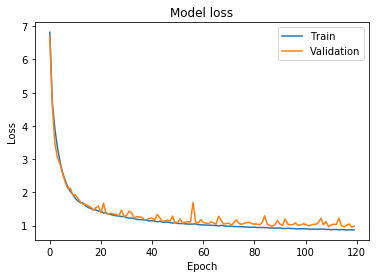

In [14]:
# (re)save and load history
import pickle

past_history = {}

try:
    pkl_file = open(HISTORY_PATH + '_history.pkl', 'rb')
    past_history = pickle.load(pkl_file)
    pkl_file.close()
except:
    pass

full_history = {}

for k in history.history:
    if k in past_history:
        full_history[k] = np.concatenate((past_history[k], history.history[k]), axis=0)
    else:
        full_history[k] = history.history[k]

pkl_file = open(HISTORY_PATH + '_history.pkl', 'wb')
pickle.dump(full_history, pkl_file)
pkl_file.close()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# summarize history for loss, second half
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Test

In [15]:
# x_test, y_test = validation_generator.next()
# import pickle 
# x_test, y_test = (train_x, train_y)
x_test, y_test = (validation_x, validation_y)
y_pred = model.predict(x_test, batch_size=10)

In [ ]:
np.save('predictions.npy', y_pred)

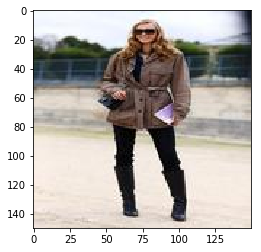

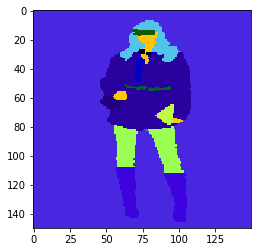

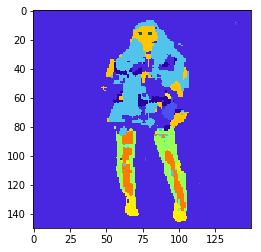

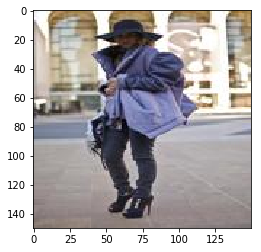

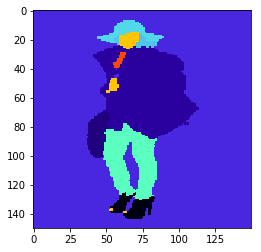

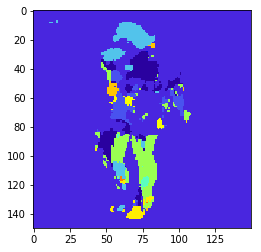

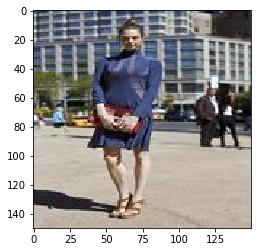

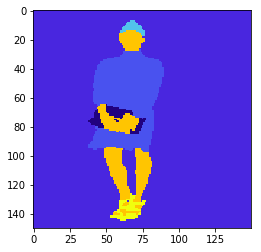

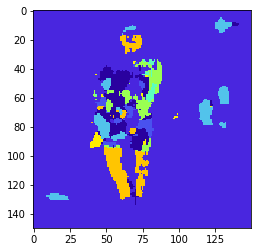

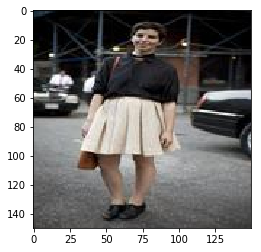

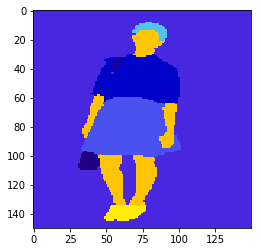

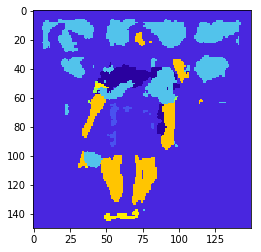

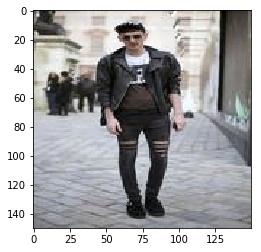

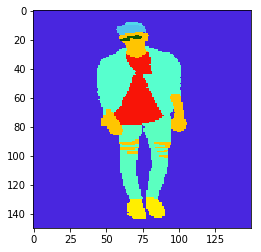

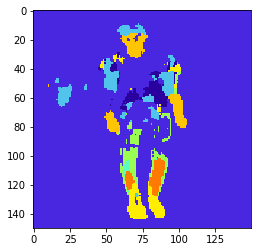

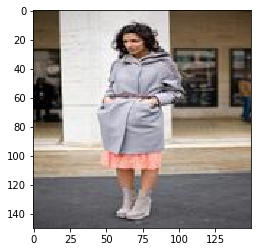

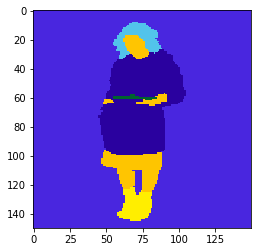

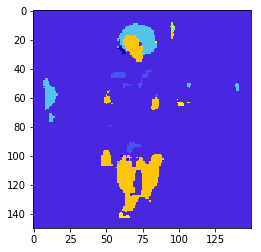

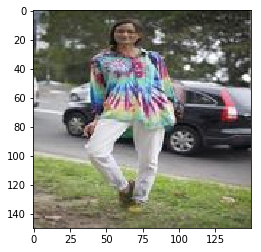

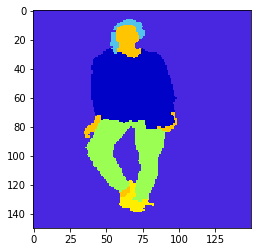

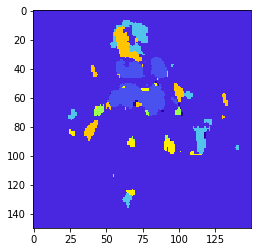

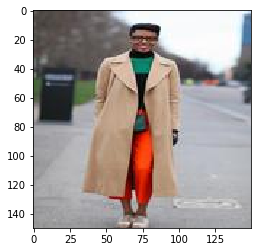

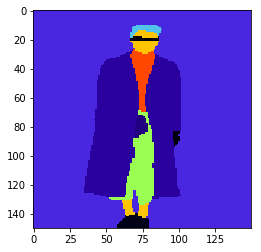

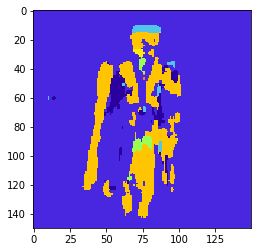

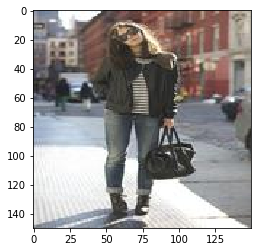

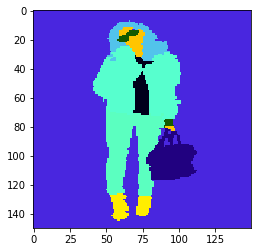

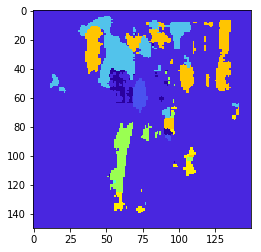

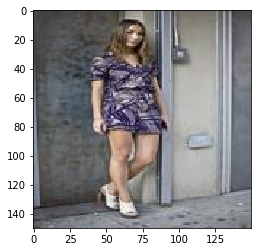

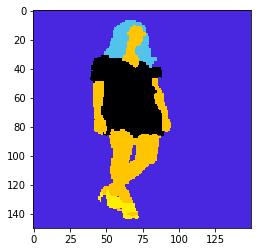

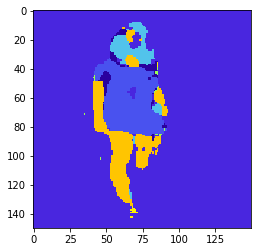

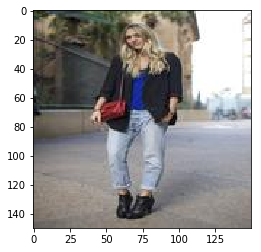

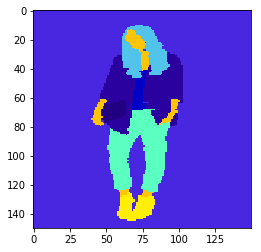

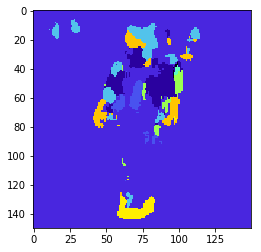

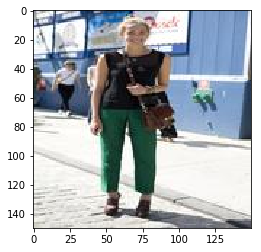

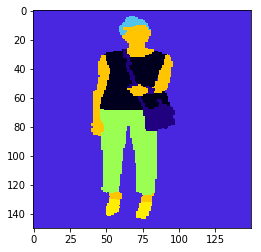

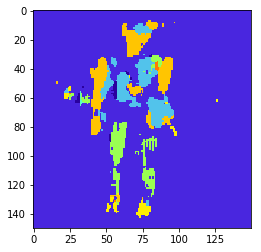

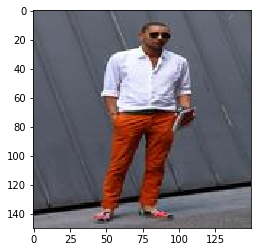

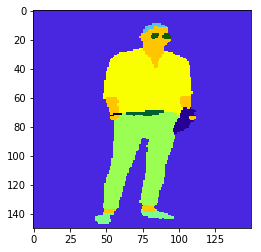

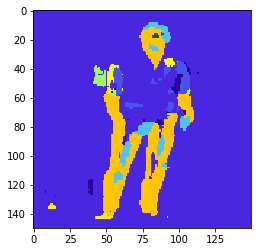

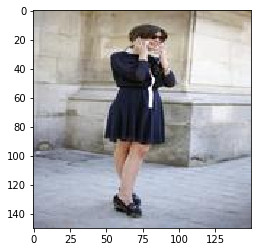

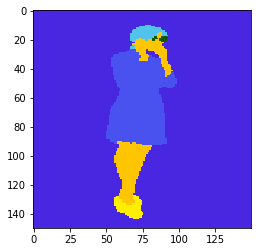

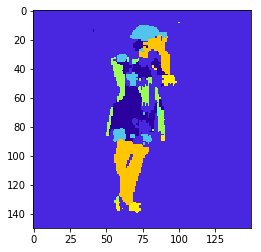

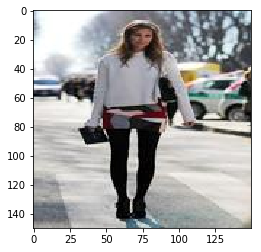

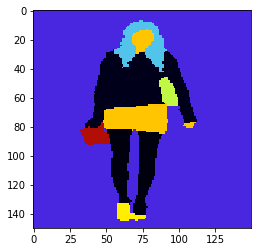

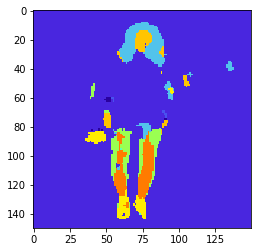

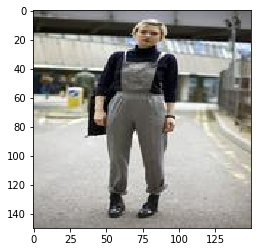

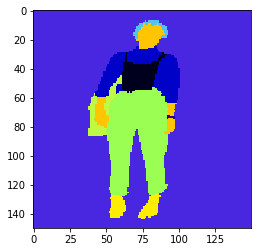

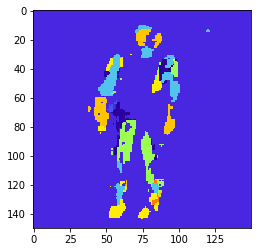

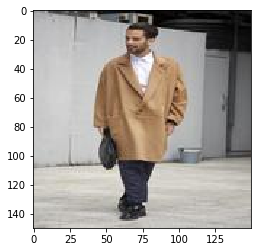

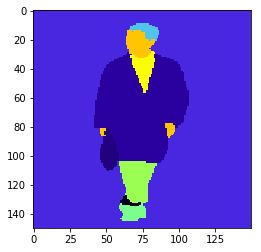

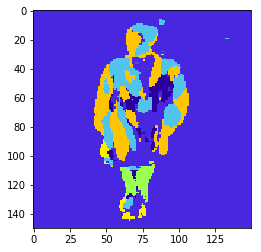

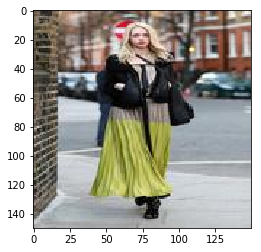

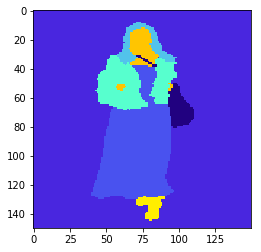

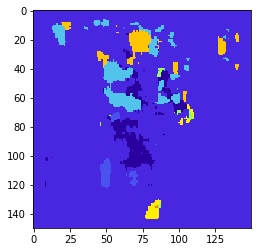

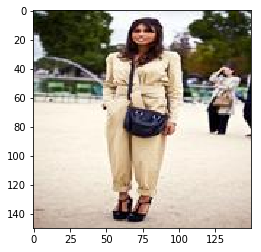

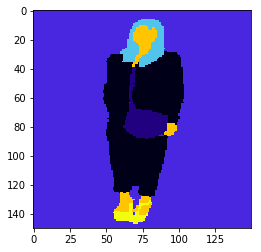

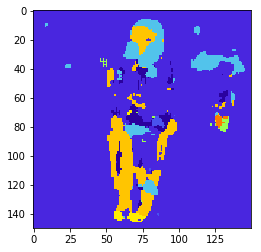

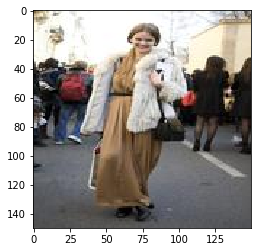

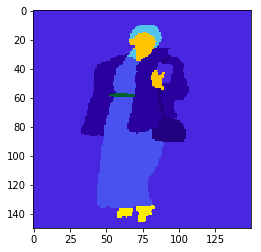

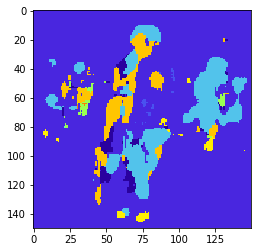

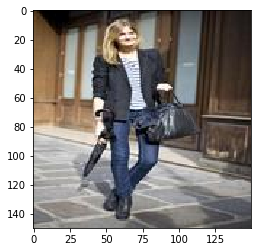

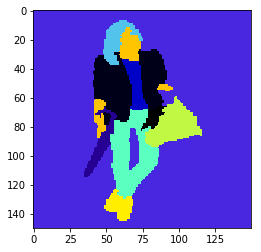

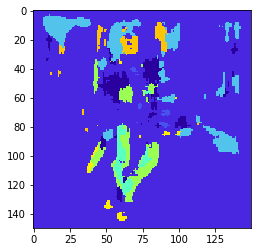

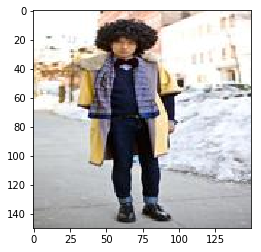

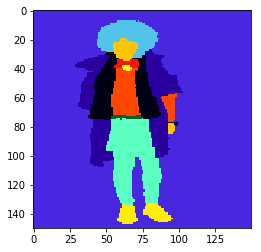

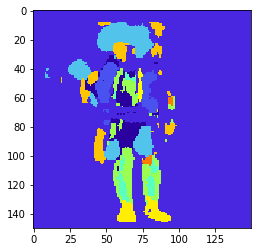

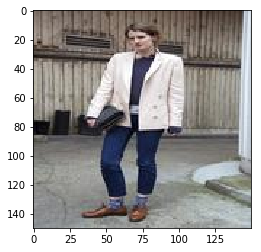

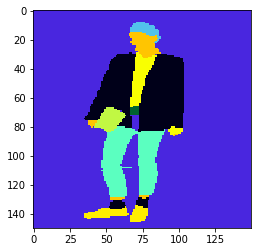

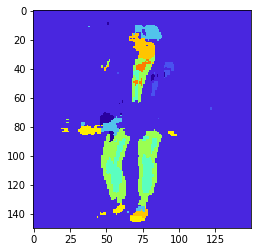

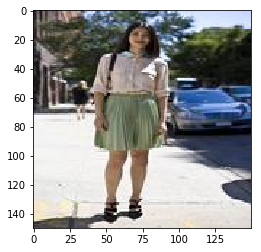

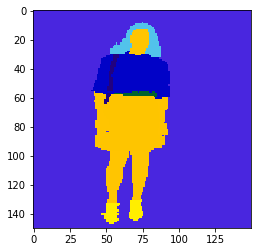

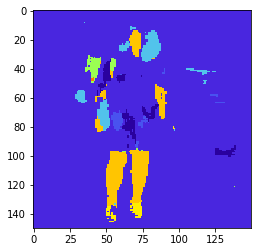

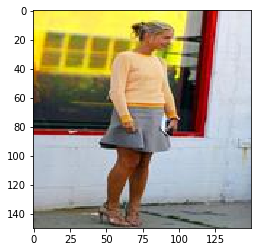

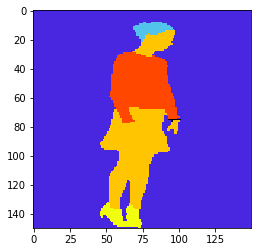

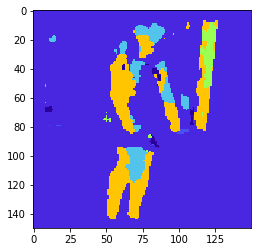

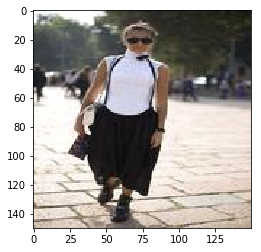

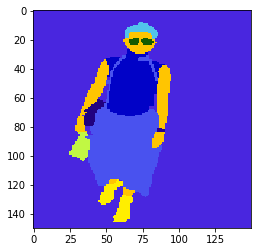

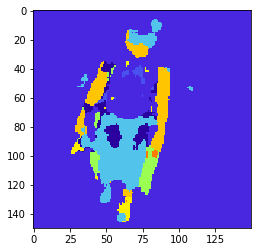

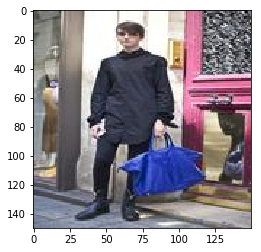

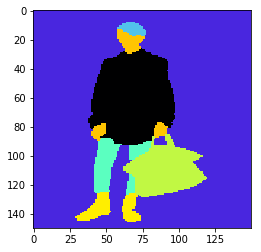

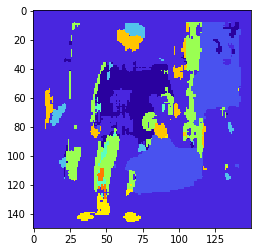

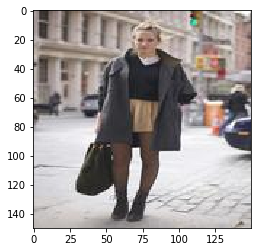

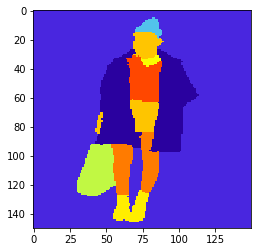

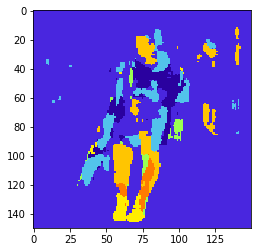

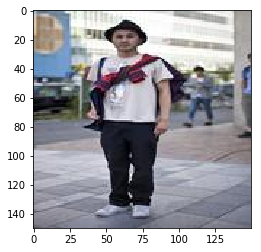

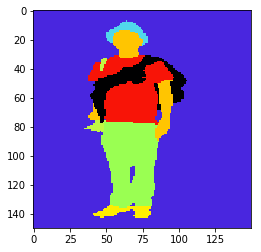

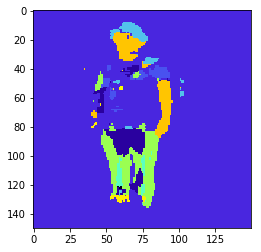

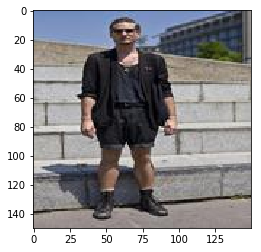

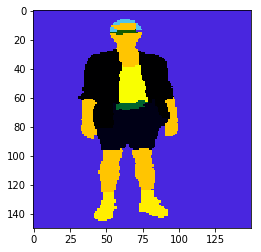

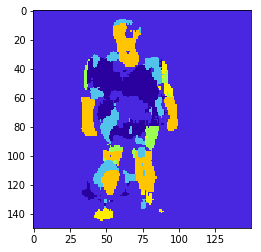

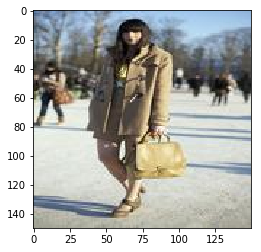

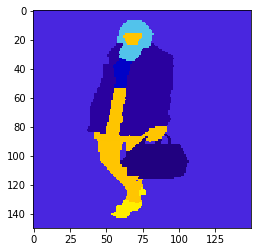

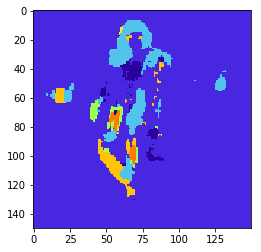

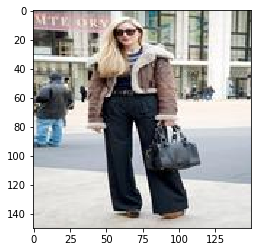

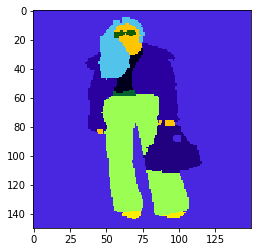

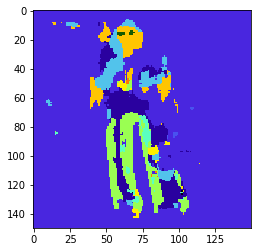

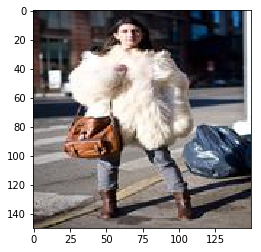

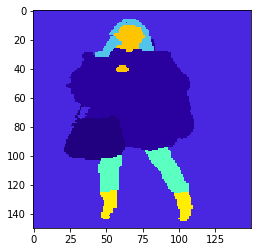

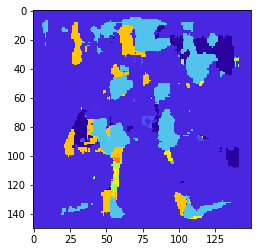

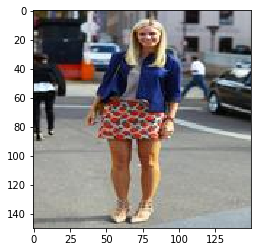

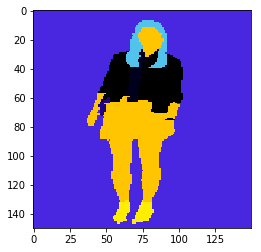

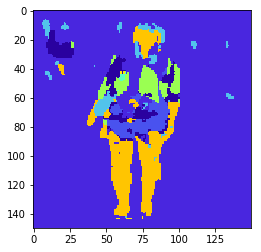

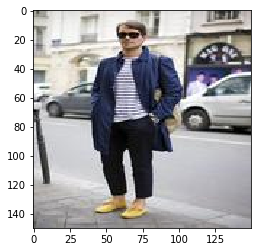

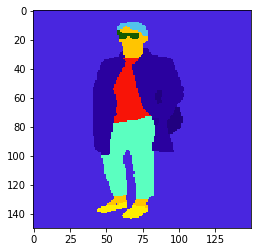

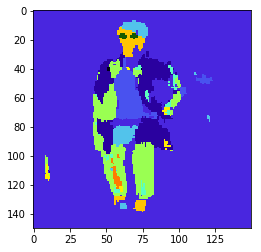

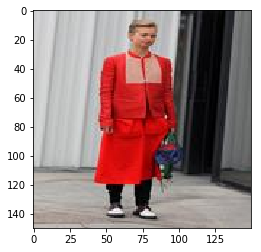

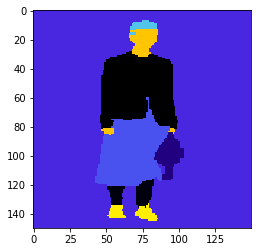

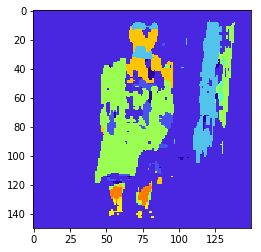

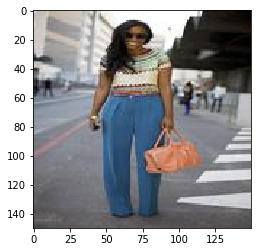

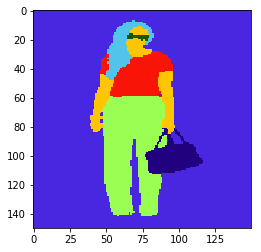

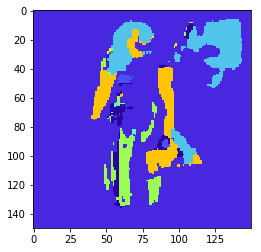

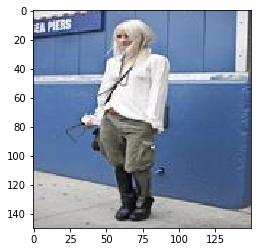

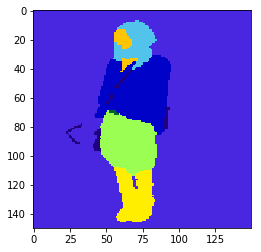

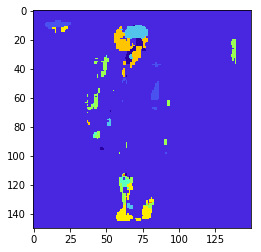

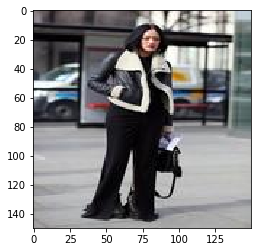

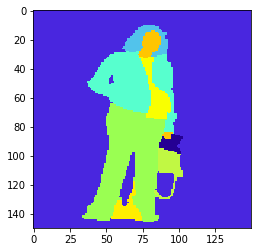

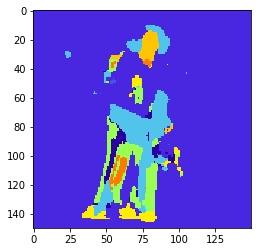

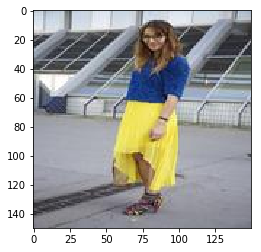

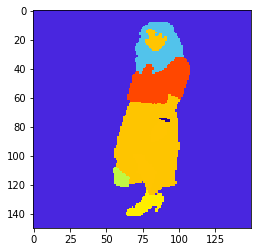

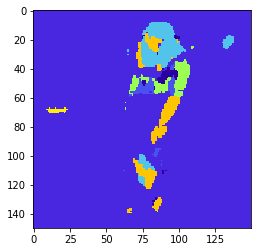

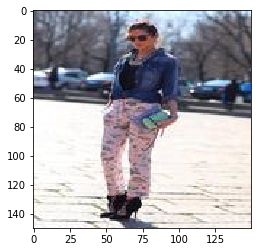

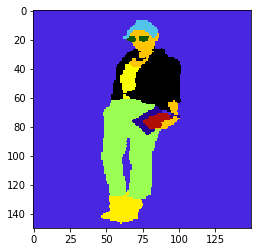

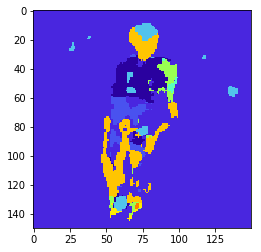

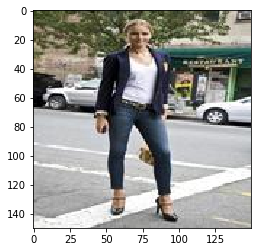

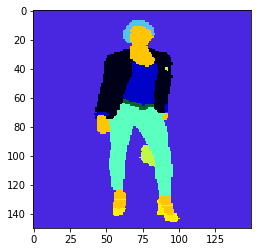

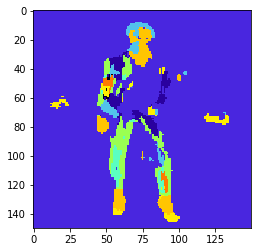

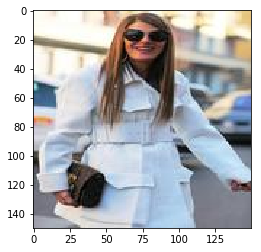

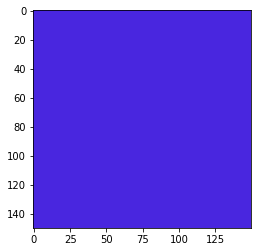

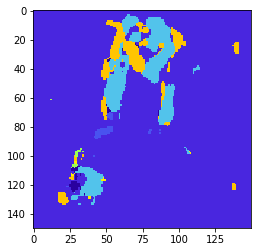

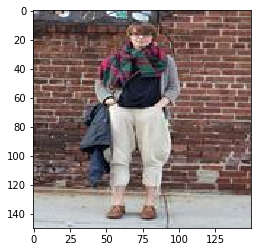

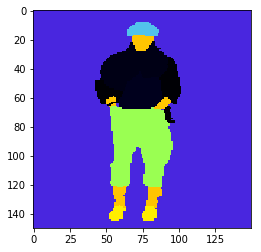

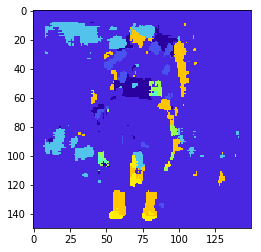

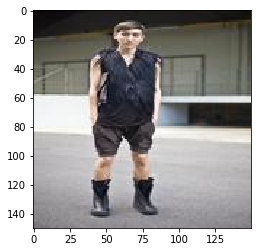

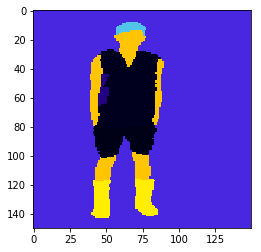

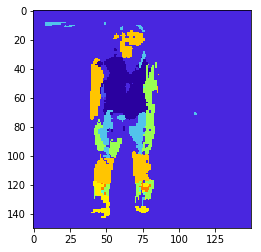

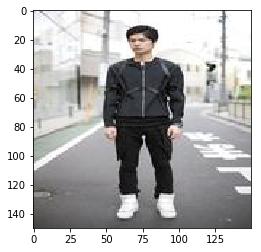

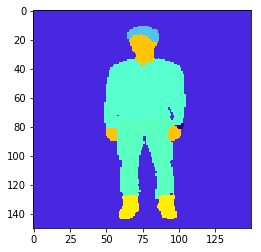

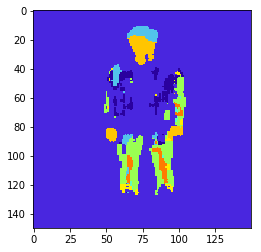

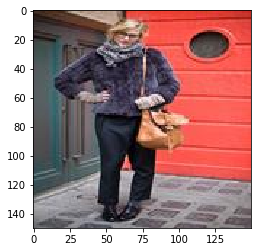

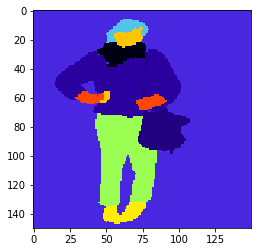

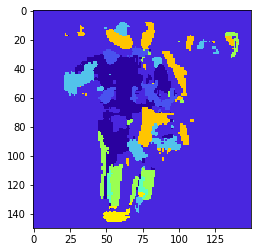

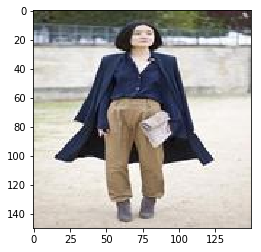

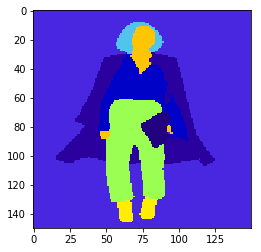

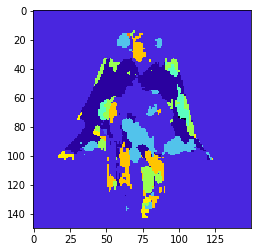

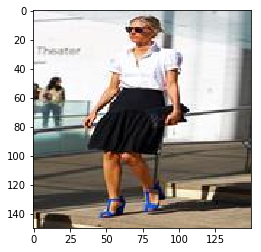

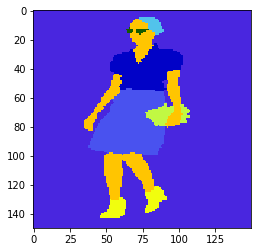

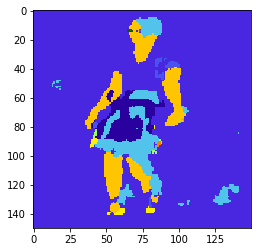

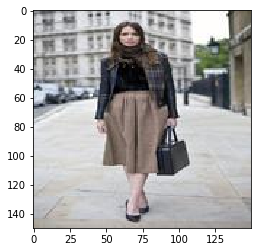

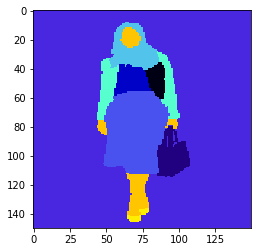

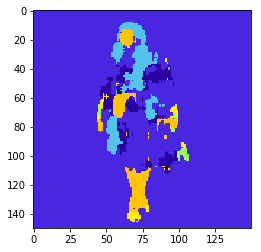

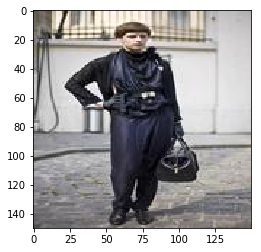

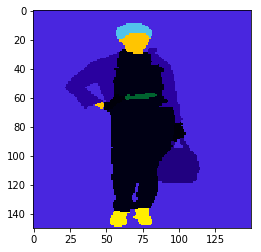

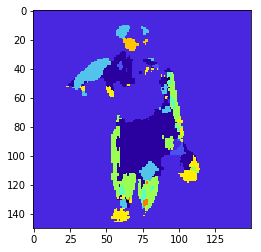

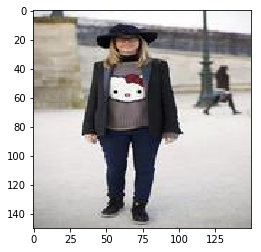

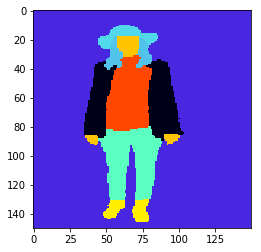

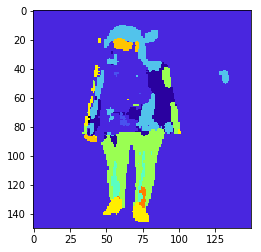

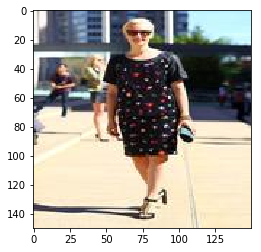

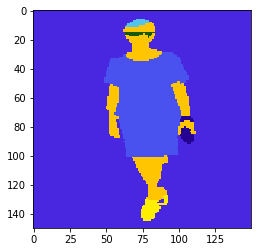

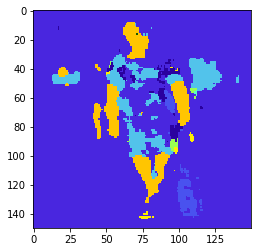

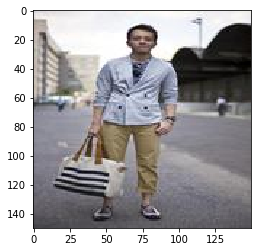

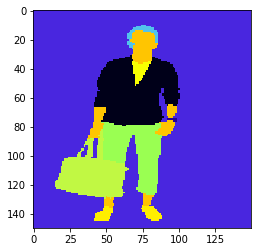

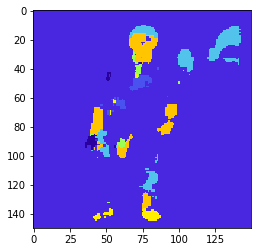

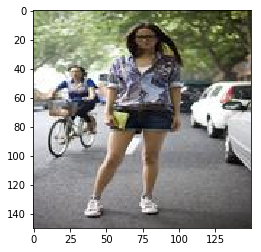

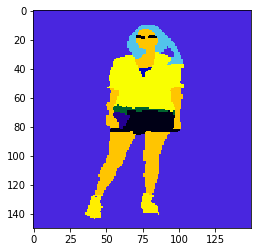

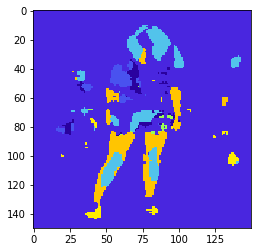

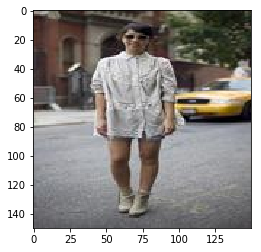

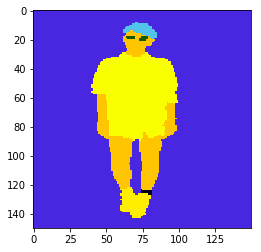

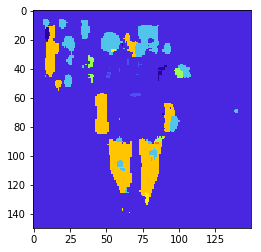

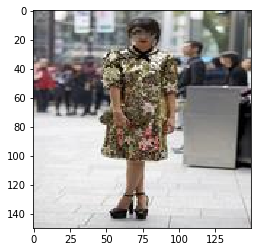

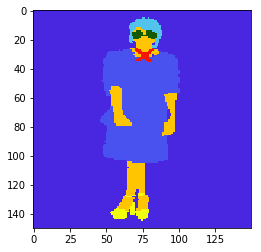

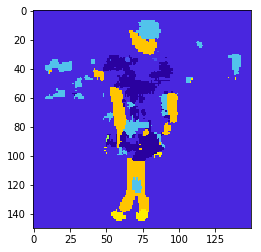

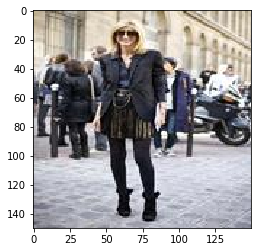

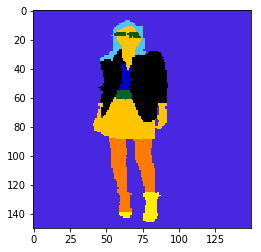

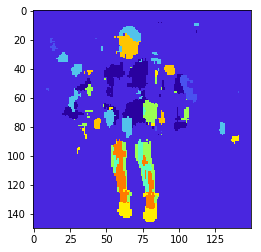

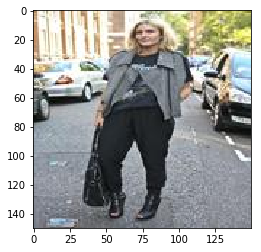

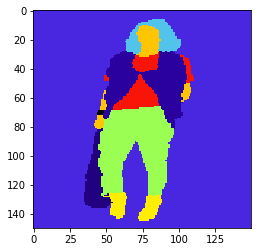

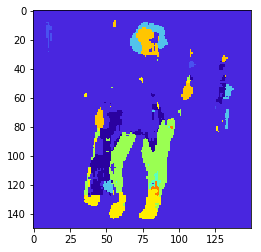

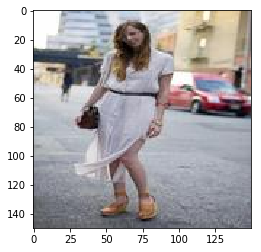

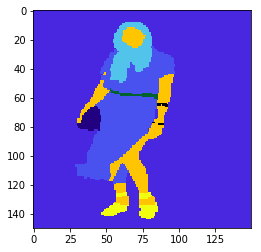

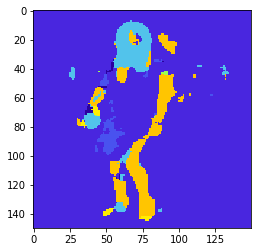

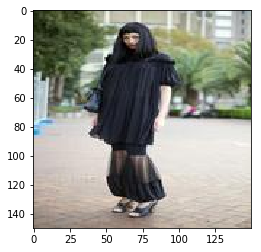

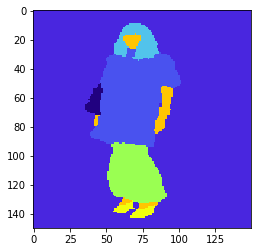

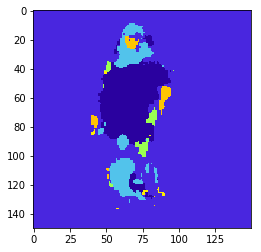

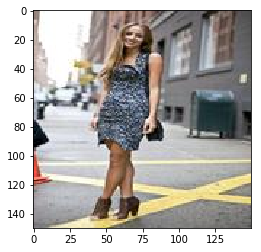

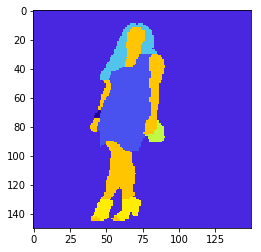

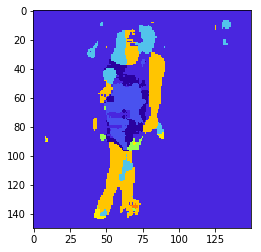

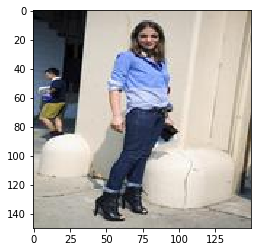

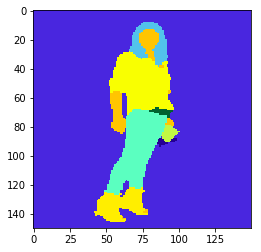

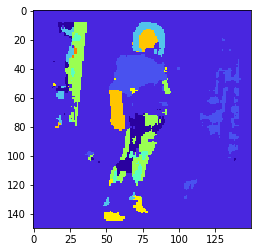

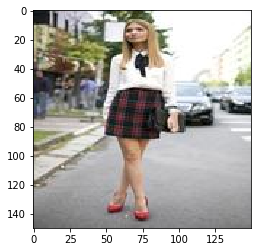

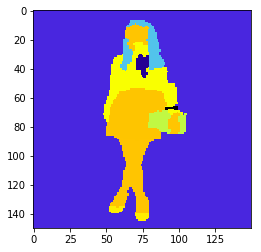

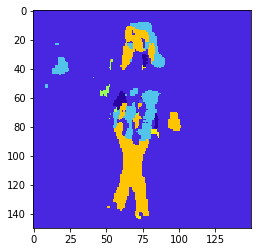

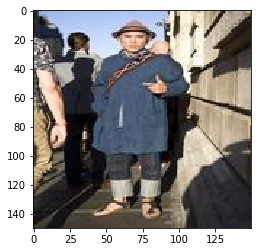

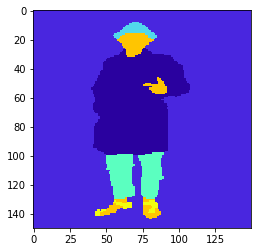

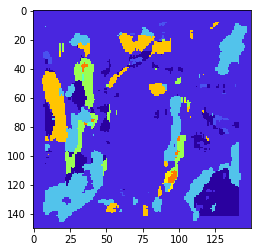

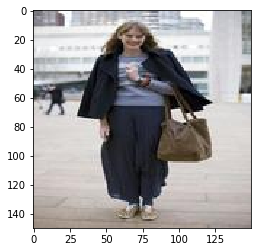

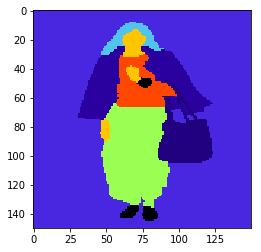

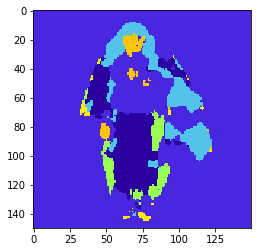

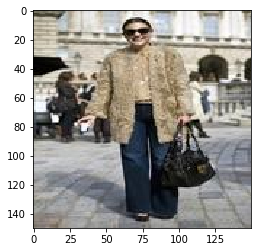

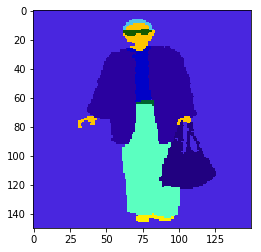

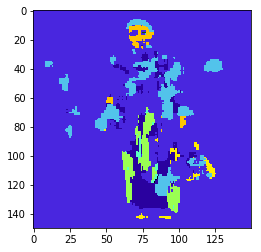

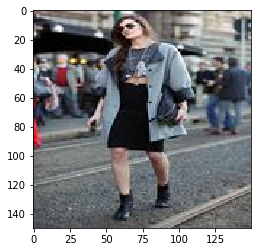

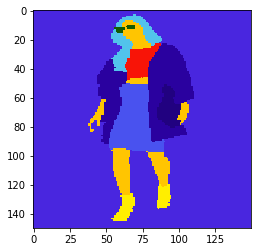

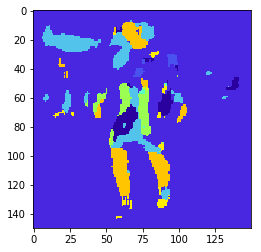

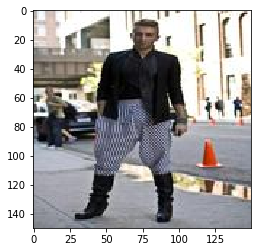

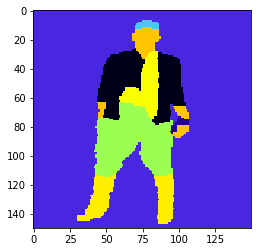

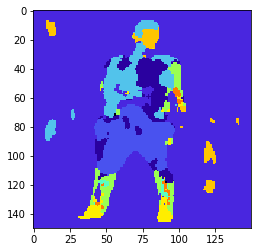

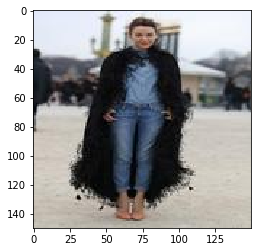

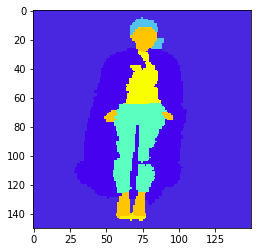

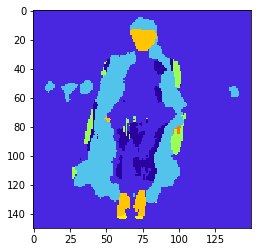

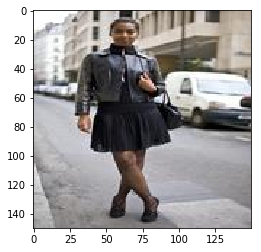

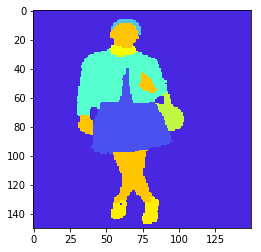

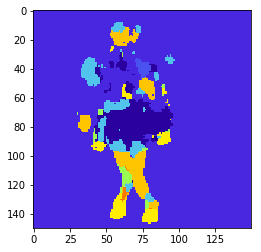

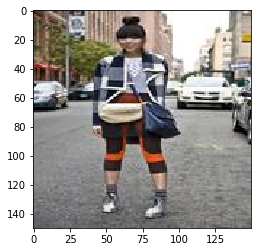

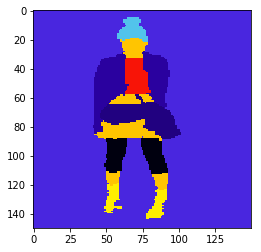

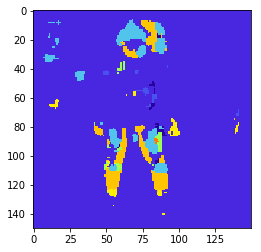

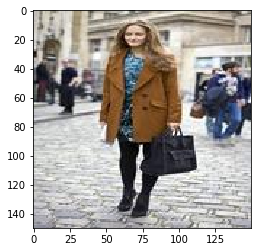

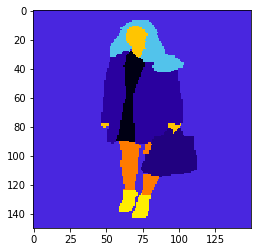

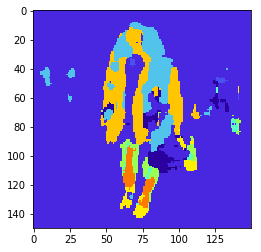

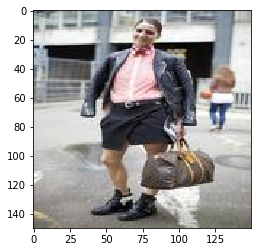

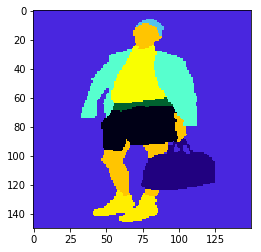

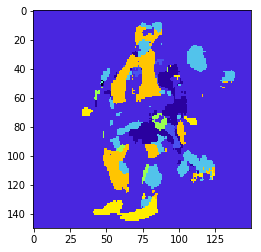

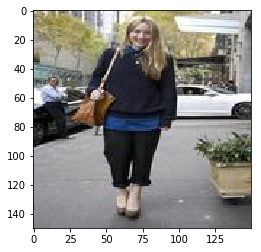

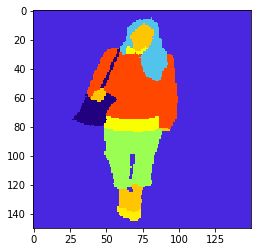

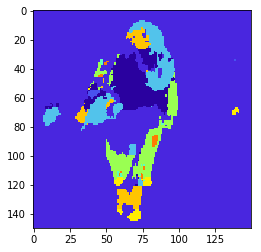

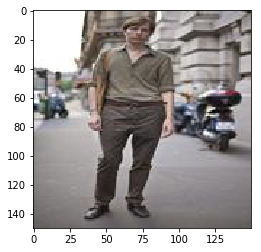

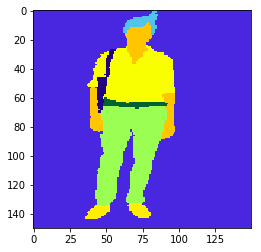

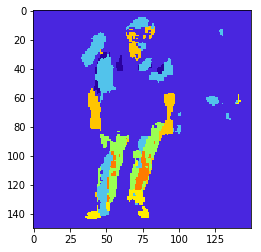

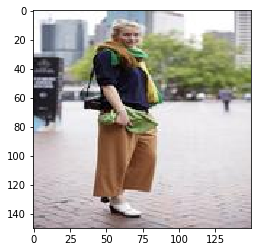

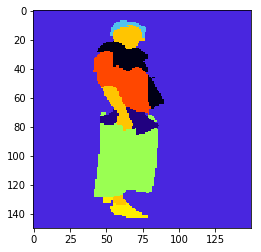

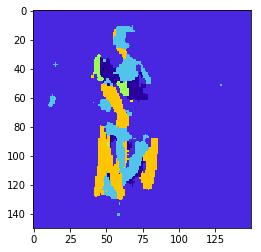

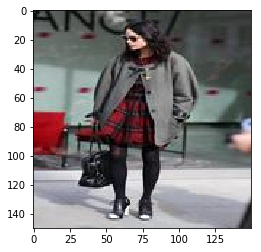

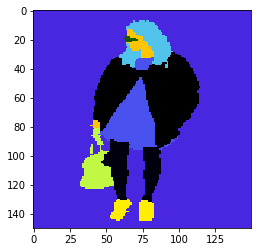

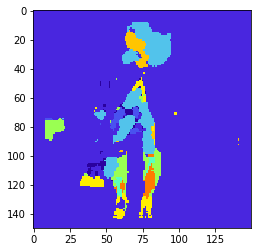

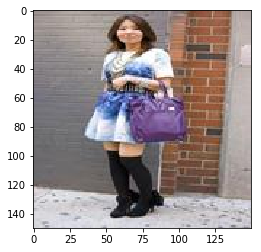

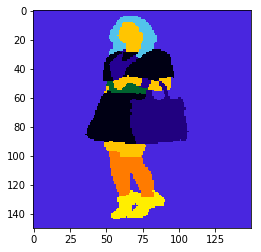

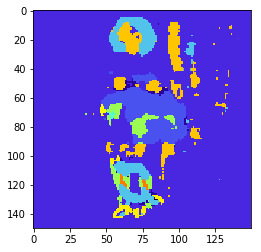

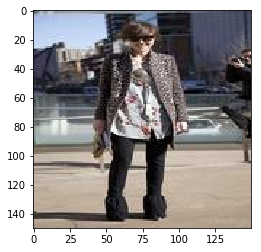

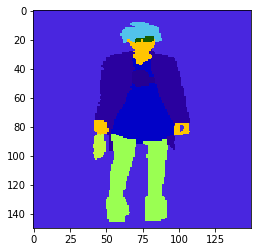

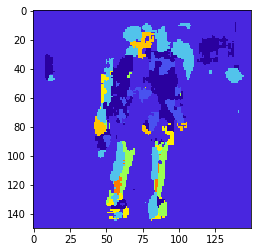

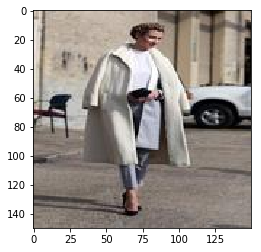

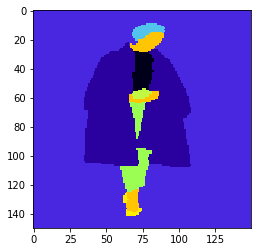

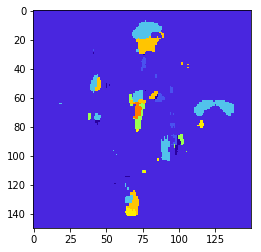

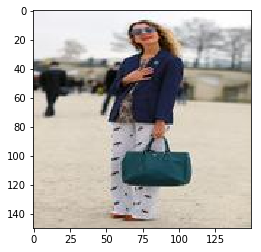

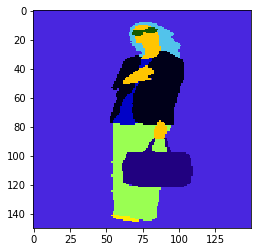

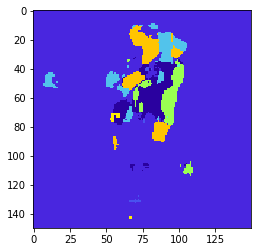

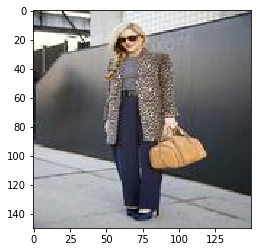

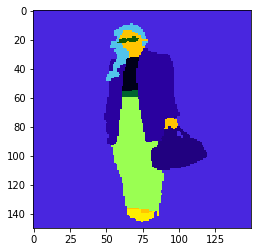

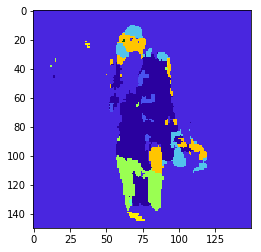

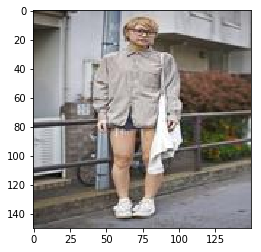

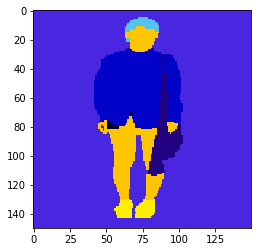

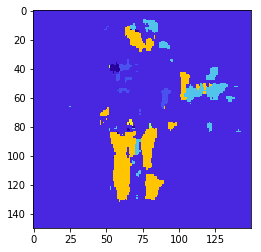

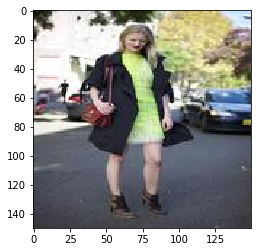

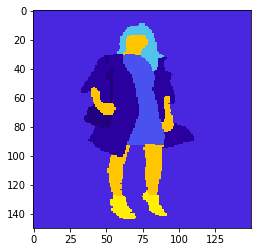

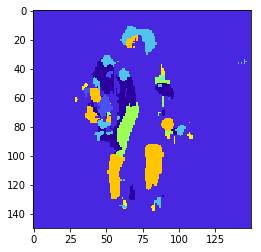

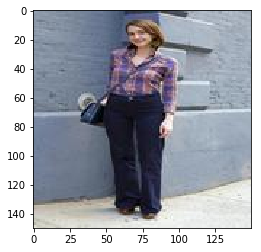

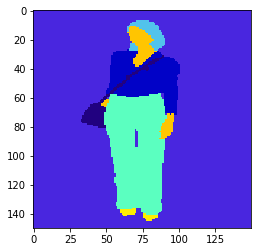

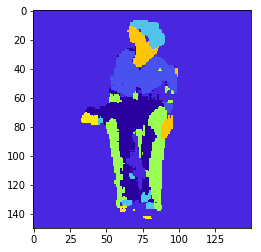

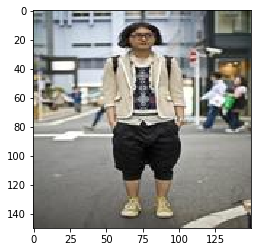

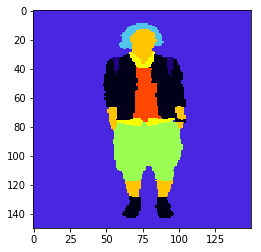

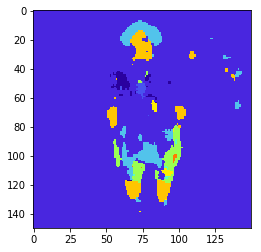

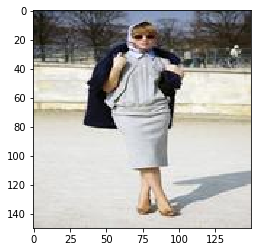

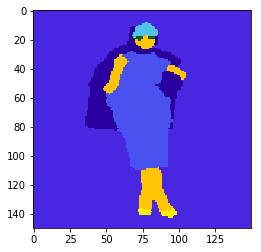

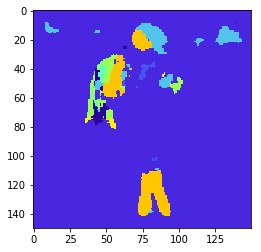

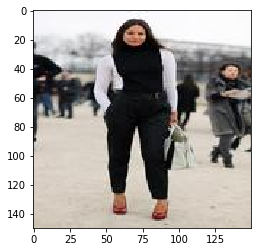

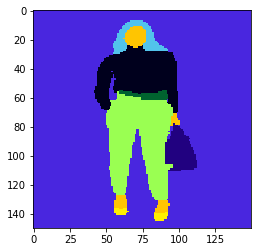

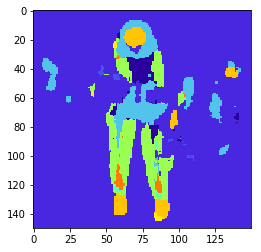

In [16]:
from util.common import to_rgb_img, to_categorical

for i in range(0,len(y_pred)):
    plt.imshow(np.uint8(x_test[i]))
    plt.show()

    plt.imshow(np.uint8(to_rgb_img(y_test[i], CCP_COLOR_MAP, argmax=True)))
    plt.show()

    plt.imshow(np.uint8(to_rgb_img(y_pred[i], CCP_COLOR_MAP, argmax=True)))
    plt.show()